In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import sklearn
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

tf.random.set_seed(0)

2023-06-22 16:28:16.506363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/namnguyen/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Neural network method in design

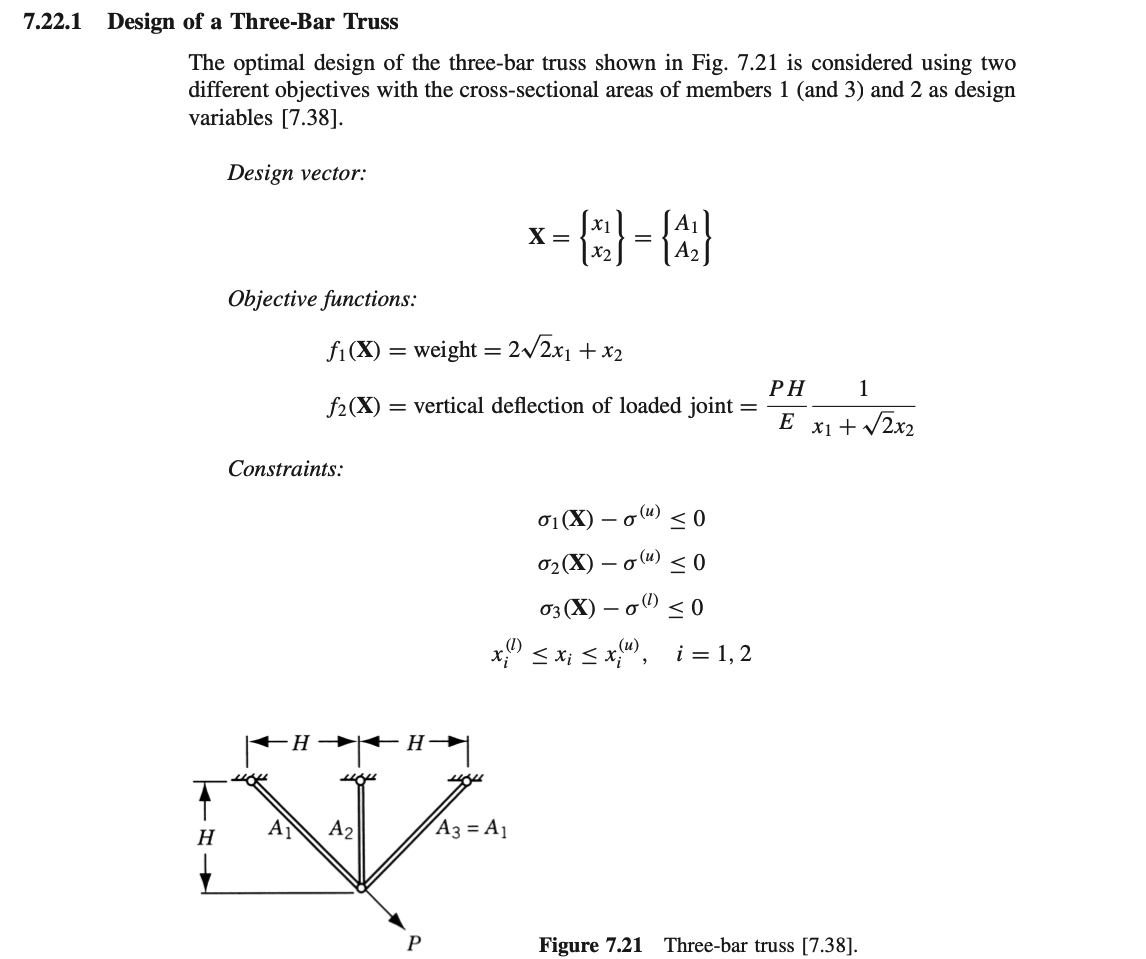

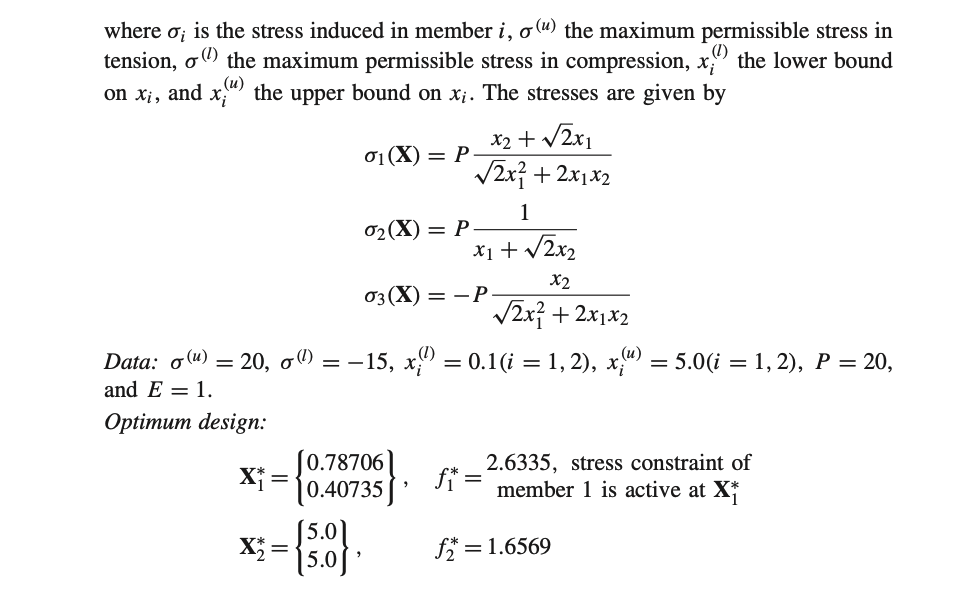


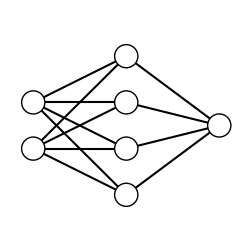

In [3]:
def draw_neural_net(left, right, bottom, top, layer_sizes):
    '''
    From https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom) / float(max(layer_sizes))
    h_spacing = (right - left) / float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing * (layer_size - 1) / 2. + (top + bottom) / 2.
        for m in range(layer_size):
            circle = plt.Circle((n * h_spacing + left, layer_top - m * v_spacing), v_spacing / 4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing * (layer_size_a - 1) / 2. + (top + bottom) / 2.
        layer_top_b = v_spacing * (layer_size_b - 1) / 2. + (top + bottom) / 2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n * h_spacing + left, (n + 1) * h_spacing + left],
                                  [layer_top_a - m * v_spacing, layer_top_b - o * v_spacing], c='k')
                ax.add_artist(line)

# test the drawing
draw_neural_net(.1, .9, .1, .9, [2, 4, 1])


In [4]:
# Define the Objective Function
def OF(X): 
    x1, x2 = X
    return 2*np.sqrt(2)*x1+x2

In [5]:
# Constrainted Optimizations:

def constraint_1(X):
    x1, x2 = X
    return P * (x2+np.sqrt(2)*x1)/(np.sqrt(2)*x1**2+2*x1*x2) - sigma_u

def constraint_2(X):
    x1, x2 = X
    return P/(x1+np.sqrt(2)*x2)- sigma_u

def constraint_3(X):
    x1, x2 = X
    return -P*x2/(np.sqrt(2)*x1**2+2*x1*x2)- sigma_l


In [6]:
# Define the constants and bounds
sigma_u = 20
sigma_l = -15
x_l = 0.1
x_u = 5.0
P = 20
E = 1

In [7]:
# Generate Training Data
np.random.seed(42)
num_samples = 1000
X_train = np.random.uniform(low=[0.1, 0.1], high=[5.0, 5.0], size=(num_samples, 2))
y_train = np.array([OF(X) for X in X_train])



In [8]:
# Create the neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, batch_size=64 ,epochs=5, validation_split=0.2, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                48        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
13/13 [==============================] - 0s 13ms/step - loss: 124.8032 - accuracy: 0.0000e+00 - val_loss: 120.3705 - val_accuracy: 0.0000e+00
Epoch 2/5
13/13 [==============================] - 0s 3ms/step - loss: 116.1466 - accuracy: 0.0000e+00 - val_loss: 112.8166 - val_accuracy: 0.0000e+00
Epoch 3/5
13/13 [==

In [9]:
# Use the trained model for predictions
X_test = np.array([[0.2, 0.2]])  # Sample design vector for testing

# Make predictions
y_pred = model.predict(X_test)

# Print the predicted objective value
print("Predicted Objective Value:", y_pred[0])

# Solve the constrained optimization problem
best_design = None
best_objective = np.inf

for x1 in np.linspace(x_l, x_u, 100):
    for x2 in np.linspace(x_l, x_u, 100):
        X = np.array([x1, x2])
        constraints = [
            constraint_1(X),
            constraint_2(X),
            constraint_3(X)
        ]
        objective = OF(X)

        if all(c <= 0 for c in constraints) and objective < best_objective:
            best_design = X
            best_objective = objective

# Print the best design and objective value
print("Best Design:", best_design)
print("Best Objective Value:", best_objective)

1/1 [==============================] - 0s 65ms/step
Predicted Objective Value: [0.30642867]
Best Design: [0.59494949 3.51515152]
Best Objective Value: 5.197922804520713
